**Import des données / Lib**

In [1]:
# 📦 Imports
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import shap

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score

df = pd.read_parquet('../data/prod/df_model_appart_2020.parquet.gz', engine='pyarrow')
# Calcul de la fréquence des communes
df

c:\Users\shipu\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,surface_reelle_bati,nombre_pieces_principales,latitude,longitude,has_dependance,nom_commune,prix_m2
0,62.0,3.0,46.198795,5.219443,True,Bourg-en-Bresse,2193.548340
1,47.0,2.0,46.307400,4.842984,True,Saint-Laurent-sur-Saône,1531.914917
2,46.0,2.0,46.205639,5.222975,False,Bourg-en-Bresse,1521.739136
3,60.0,2.0,46.208492,5.220961,True,Bourg-en-Bresse,583.333313
4,55.0,2.0,46.248257,5.130623,True,Polliat,2215.109619
...,...,...,...,...,...,...,...
190517,15.0,1.0,48.868458,2.345359,False,Paris 2e Arrondissement,9419.533203
190518,57.0,3.0,48.865822,2.342885,False,Paris 2e Arrondissement,12894.737305
190519,74.0,3.0,48.867874,2.352858,False,Paris 2e Arrondissement,9459.458984
190520,32.0,2.0,48.855644,2.367553,False,Paris 4e Arrondissement,11093.750000


**Random Forest**

In [2]:
# --- Encodage boolean ---
df["has_dependance"] = df["has_dependance"].astype(int)

# --- Définir features de base et target ---
FEATURES_BASE = [
    "surface_reelle_bati",
    "nombre_pieces_principales",
    "latitude",
    "longitude",
    "has_dependance",
]

TARGET = "prix_m2"

X = df[FEATURES_BASE + ["nom_commune"]].copy()
y = df[TARGET]

# --- Split train/test AVANT feature engineering ---
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

# --- Créer feature nb_ventes_commune sur TRAIN uniquement ---
commune_sales = (
    X_train.groupby("nom_commune")
           .size()
           .rename("nb_ventes_commune")
)

# --- Appliquer au train et au test ---
X_train = X_train.merge(
    commune_sales,
    on="nom_commune",
    how="left"
)

X_test = X_test.merge(
    commune_sales,
    on="nom_commune",
    how="left"
)

# --- Gérer communes jamais vues dans le test ---
median_sales = commune_sales.median()

X_train["nb_ventes_commune"] = X_train["nb_ventes_commune"].fillna(median_sales)
X_test["nb_ventes_commune"] = X_test["nb_ventes_commune"].fillna(median_sales)

# --- Sélection finale des features ---
FEATURES_FINAL = FEATURES_BASE + ["nb_ventes_commune"]
X_train_final = X_train[FEATURES_FINAL]
X_test_final = X_test[FEATURES_FINAL]

# --- Entraînement Random Forest ---
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=22,
    min_samples_leaf=20,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_final, y_train)

# --- Prédictions et évaluation ---
y_pred = rf_model.predict(X_test_final)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Random Forest")
print("RMSE :", rmse)
print("R2   :", r2)

# --- Importance des features ---
importances = pd.Series(
    rf_model.feature_importances_,
    index=FEATURES_FINAL
).sort_values(ascending=False)

print("\nImportance des features :")
print(importances)

Random Forest
RMSE : 1055.2417058588
R2   : 0.8334907754404861

Importance des features :
latitude                     0.654240
longitude                    0.163473
nb_ventes_commune            0.147776
surface_reelle_bati          0.028748
has_dependance               0.003677
nombre_pieces_principales    0.002086
dtype: float64


**GradientBoostingRegressor**

In [ ]:
# --- Encodage booléen ---
df["has_dependance"] = df["has_dependance"].astype(int)

# --- 2️⃣ Définir features de base et target ---
FEATURES_BASE = [
    "surface_reelle_bati",
    "nombre_pieces_principales",
    "latitude",
    "longitude",
    "has_dependance",
]

TARGET = "prix_m2"

X = df[FEATURES_BASE + ["nom_commune"]].copy()
y = df[TARGET]

# --- Split train/test AVANT feature engineering ---
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

# --- Créer feature nb_ventes_commune sur TRAIN uniquement ---
commune_sales = (
    X_train.groupby("nom_commune")
           .size()
           .rename("nb_ventes_commune")
)

# --- Appliquer au train et au test ---
X_train = X_train.merge(
    commune_sales,
    on="nom_commune",
    how="left"
)

X_test = X_test.merge(
    commune_sales,
    on="nom_commune",
    how="left"
)

# --- Gérer communes jamais vues dans le test ---
median_sales = commune_sales.median()

X_train["nb_ventes_commune"] = X_train["nb_ventes_commune"].fillna(median_sales)
X_test["nb_ventes_commune"] = X_test["nb_ventes_commune"].fillna(median_sales)

# --- Sélection finale des features ---
FEATURES_FINAL = FEATURES_BASE + ["nb_ventes_commune"]
X_train_final = X_train[FEATURES_FINAL]
X_test_final = X_test[FEATURES_FINAL]

# --- Entraînement Gradient Boosting ---
gbr_model = GradientBoostingRegressor(
    n_estimators=300,
    max_depth=5,
    min_samples_leaf=20,
    learning_rate=0.1,
    random_state=42
)

gbr_model.fit(X_train_final, y_train)

# --- Prédictions et évaluation ---
y_pred = gbr_model.predict(X_test_final)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Gradient Boosting Regressor")
print("RMSE :", rmse)
print("R2   :", r2)

# --- Importance des features ---
importances = pd.Series(
    gbr_model.feature_importances_,
    index=FEATURES_FINAL
).sort_values(ascending=False)

print("\nImportance des features :")
print(importances)

Gradient Boosting Regressor
RMSE : 1115.2213351384414
R2   : 0.8140241543399761

Importance des features :
latitude                     0.650219
longitude                    0.166097
nb_ventes_commune            0.148249
surface_reelle_bati          0.028423
nombre_pieces_principales    0.003620
has_dependance               0.003393
dtype: float64


**LightGBM**

In [ ]:
# --- Encodage booléen ---
df["has_dependance"] = df["has_dependance"].astype(int)

# --- Définir features de base et target ---
FEATURES_BASE = [
    "surface_reelle_bati",
    "nombre_pieces_principales",
    "latitude",
    "longitude",
    "has_dependance",
]

TARGET = "prix_m2"

X = df[FEATURES_BASE + ["nom_commune"]].copy()
y = df[TARGET]

# --- Split train/test AVANT feature engineering ---
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

# --- Créer feature nb_ventes_commune sur TRAIN uniquement ---
commune_sales = (
    X_train.groupby("nom_commune")
           .size()
           .rename("nb_ventes_commune")
)

# --- Appliquer au train et au test ---
X_train = X_train.merge(
    commune_sales,
    on="nom_commune",
    how="left"
)

X_test = X_test.merge(
    commune_sales,
    on="nom_commune",
    how="left"
)

# --- Gérer communes jamais vues dans le test ---
median_sales = commune_sales.median()

X_train["nb_ventes_commune"] = X_train["nb_ventes_commune"].fillna(median_sales)
X_test["nb_ventes_commune"] = X_test["nb_ventes_commune"].fillna(median_sales)

# --- Sélection finale des features ---
FEATURES_FINAL = FEATURES_BASE + ["nb_ventes_commune"]
X_train_final = X_train[FEATURES_FINAL]
X_test_final = X_test[FEATURES_FINAL]

# --- Entraînement LightGBM ---
lgb_model = LGBMRegressor(
    n_estimators=1000,
    max_depth=5,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42,
    verbose=-1  # 🔹 pas de logs LightGBM
)

lgb_model.fit(X_train_final, y_train)

# Évaluation
y_pred = lgb_model.predict(X_test_final)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("LightGBM Regressor")
print("RMSE :", rmse)
print("R2   :", r2)

# Importances utiles seulement
importances = pd.Series(
    lgb_model.feature_importances_,
    index=FEATURES_FINAL
).sort_values(ascending=False)
print("\nImportance des features :")
print(importances[importances > 0])

LightGBM Regressor
RMSE : 1105.0476386270318
R2   : 0.8174018364370954

Importance des features :
latitude                     8114
longitude                    7510
nb_ventes_commune            5299
surface_reelle_bati          4333
nombre_pieces_principales     915
has_dependance                557
dtype: int32


**Prédiction uniquement sur Paris**

In [ ]:
df_paris = df[
    df["nom_commune"].str.contains("Paris", case=False, na=False)
    & ~df["nom_commune"].str.contains("Seyssinet-Pariset|Le Touquet-Paris-Plage|Villeparisis|Fontenay-en-Parisis|Cormeilles-en-Parisis", case=False, na=False)
]["nom_commune"].unique()
print(df_paris)

['Paris 3e Arrondissement' 'Paris 1er Arrondissement'
 'Paris 8e Arrondissement' 'Paris 20e Arrondissement'
 'Paris 17e Arrondissement' 'Paris 10e Arrondissement'
 'Paris 18e Arrondissement' 'Paris 4e Arrondissement'
 'Paris 7e Arrondissement' 'Paris 5e Arrondissement'
 'Paris 6e Arrondissement' 'Paris 11e Arrondissement'
 'Paris 9e Arrondissement' 'Paris 12e Arrondissement'
 'Paris 13e Arrondissement' 'Paris 14e Arrondissement'
 'Paris 15e Arrondissement' 'Paris 16e Arrondissement'
 'Paris 19e Arrondissement' 'Paris 2e Arrondissement']


In [74]:
print("Filtré sur :")
df_paris = df[
    df["nom_commune"].str.contains("Paris", case=False, na=False)
    & ~df["nom_commune"].str.contains("Seyssinet-Pariset|Le Touquet-Paris-Plage|Villeparisis|Fontenay-en-Parisis|Cormeilles-en-Parisis", case=False, na=False)
]["nom_commune"].unique()
print(df_paris)

df_paris = df[
    df["nom_commune"].str.contains("Paris", case=False, na=False)
    & ~df["nom_commune"].str.contains("Seyssinet-Pariset|Le Touquet-Paris-Plage|Villeparisis|Fontenay-en-Parisis|Cormeilles-en-Parisis", case=False, na=False)
].copy()

df_paris["has_dependance"] = df_paris["has_dependance"].astype(int)

X_paris = df_paris[FEATURES_BASE + ["nom_commune"]].copy()

X_paris = X_paris.merge(commune_sales, on="nom_commune", how="left")
X_paris["nb_ventes_commune"] = X_paris["nb_ventes_commune"].fillna(median_sales)

X_paris_final = X_paris[FEATURES_FINAL]

y_pred_paris = rf_model.predict(X_paris_final)


#  RÉSULTATS PARIS

df_result_paris = df_paris.copy()
df_result_paris["prix_m2_pred"] = y_pred_paris

# (Optionnel) métriques Paris
print("\nParis uniquement")
print("RMSE :", np.sqrt(mean_squared_error(df_result_paris["prix_m2"], y_pred_paris)))
print("R2   :", r2_score(df_result_paris["prix_m2"], y_pred_paris))

Filtré sur :
['Paris 3e Arrondissement' 'Paris 1er Arrondissement'
 'Paris 8e Arrondissement' 'Paris 20e Arrondissement'
 'Paris 17e Arrondissement' 'Paris 10e Arrondissement'
 'Paris 18e Arrondissement' 'Paris 4e Arrondissement'
 'Paris 7e Arrondissement' 'Paris 5e Arrondissement'
 'Paris 6e Arrondissement' 'Paris 11e Arrondissement'
 'Paris 9e Arrondissement' 'Paris 12e Arrondissement'
 'Paris 13e Arrondissement' 'Paris 14e Arrondissement'
 'Paris 15e Arrondissement' 'Paris 16e Arrondissement'
 'Paris 19e Arrondissement' 'Paris 2e Arrondissement']

Paris uniquement
RMSE : 2110.597990420235
R2   : 0.21953957545657277


# Interpretation des données

**IMPORTANCE DES FEATURES**

In [3]:
perm = permutation_importance(
    rf_model,
    X_test_final,
    y_test,
    n_repeats=5,
    random_state=42,
    n_jobs=-1,
    scoring="r2"
)

perm_importance = (
    pd.Series(perm.importances_mean, index=FEATURES_FINAL)
    .sort_values(ascending=False)
)

print("\n🔹 Permutation importance :")
print(perm_importance)


🔹 Permutation importance :
latitude                     1.407352
longitude                    0.546869
nb_ventes_commune            0.176788
surface_reelle_bati          0.038979
has_dependance               0.006083
nombre_pieces_principales    0.001263
dtype: float64


**Summary Plot**


Ce diagramme SHAP montre que la localisation du bien (latitude et longitude) est le facteur le plus déterminant dans la prédiction du prix au m², ce qui confirme l’importance de l’emplacement sur le marché immobilier. Le nombre de ventes dans la commune influence fortement la prédiction

En revanche, la surface du bâti, la présence de dépendances et le nombre de pièces ont un impact plus limité sur le prix au m². 

Globalement, le modèle met en évidence des relations cohérentes avec les caractéristiques économiques du marché immobilier.

100%|██████████| 1000/1000 [01:47<00:00,  9.29it/s]


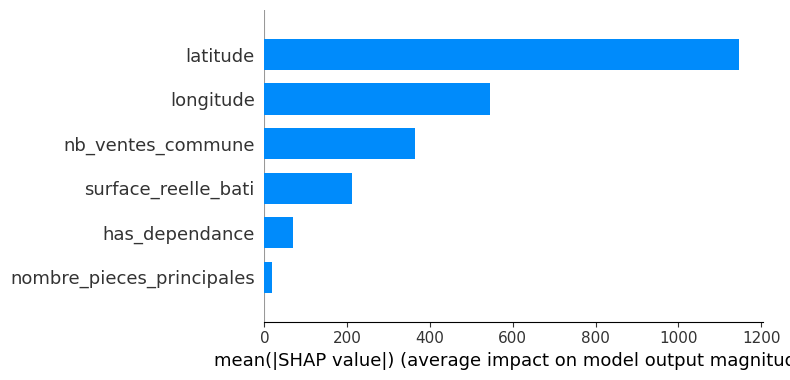

In [14]:
X_shap = X_test_final.sample(
    min(1000, len(X_test_final)),
    random_state=42
)

background = shap.sample(
    X_train_final,
    min(100, len(X_train_final)),
    random_state=42
)

explainer = shap.KernelExplainer(
    rf_model.predict,
    background
)

shap_values = explainer.shap_values(
    X_shap,
    nsamples=100
)

shap.summary_plot(shap_values, X_shap, plot_type="bar")



**EXPLICATION LOCALE**

Ce graphique SHAP illustre la décomposition de la prédiction du prix au m² pour un bien donné. 

La prédiction finale (environ 4 550 €/m²) résulte d’une valeur de base du modèle, ajustée par l’influence des différentes variables. 


Les variables en rouge (notamment le nombre de ventes dans la commune et la longitude) contribuent à augmenter le prix au m² prédit, 

tandis que les variables en bleu (comme la latitude, la surface du bâti et l’absence de dépendance) ont un effet réducteur.

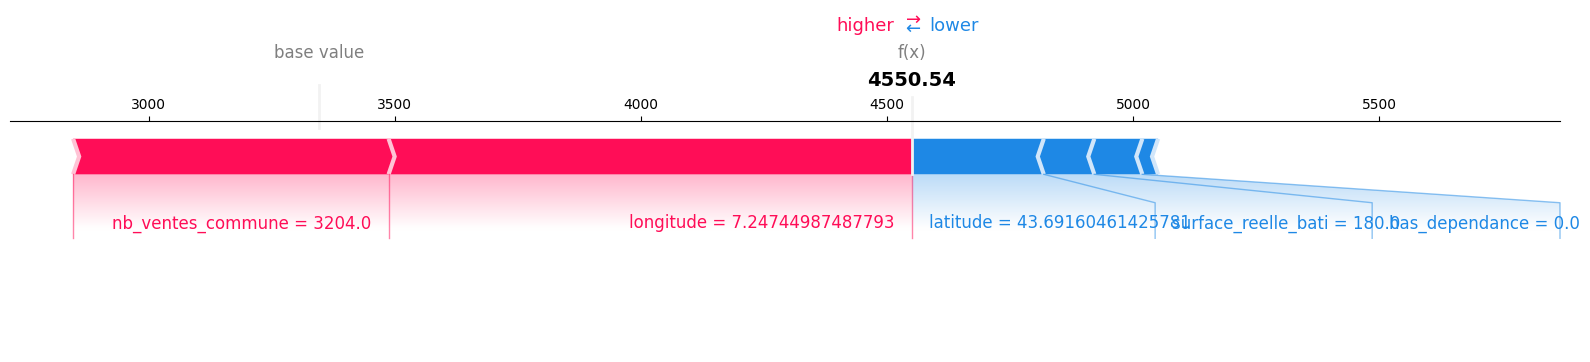

In [ ]:
i = 0
shap.force_plot(
    explainer.expected_value,
    shap_values[i],
    X_shap.iloc[i],
    matplotlib=True
)

**PARTIAL DEPENDENCE**

On peut très clairement voir sur le graphique que plus il y a de vente dans la commune moins la surface est grande

ce qui peut très facilement s'expliquer par la densité de personne au m² plus la métropole est grande plus les surfaces habitables sont petites

c:\Users\shipu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\inspection\_partial_dependence.py:717: FutureWarning: The column 5 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


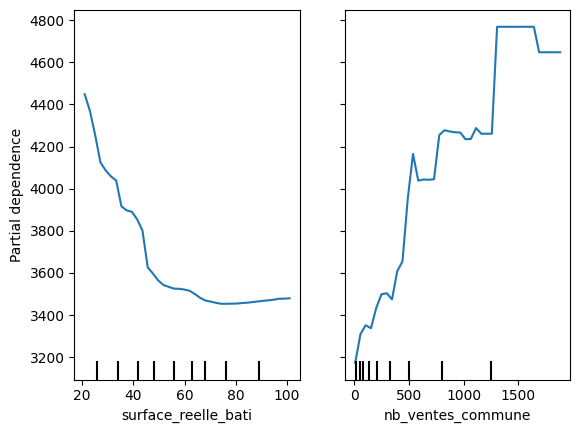

In [6]:
PartialDependenceDisplay.from_estimator(
    rf_model,
    X_train_final,
    ["surface_reelle_bati", "nb_ventes_commune"],
    grid_resolution=40
)
plt.show()


**DISTRIBUTION DES ERREURS**

Le graphique montre que le modele arrive moins à prédire les habitations avec un faible prix au m² très probablement car il y a moins de données 

concernant celles ci

A l'inverse il ne semble pas avoir de difficulté quand il s'agit de prix élevé encore une fois probablement car il y a plus de données 

car > métropole > plus de gens > plus de vente > plus de données

MAE : 683.7465420723892


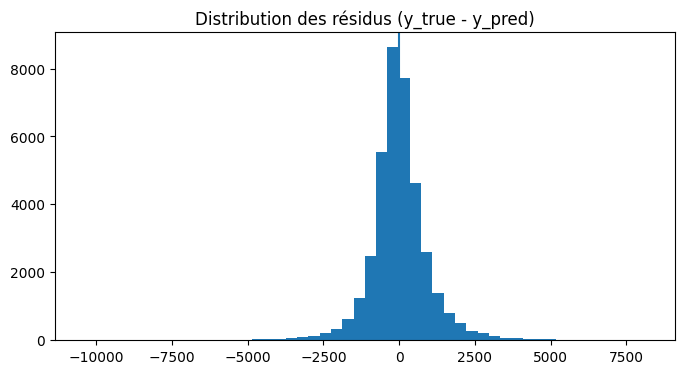

🔎 90% des erreurs absolues < 1500.5439754983754


In [11]:
residuals = y_test - y_pred
abs_error = np.abs(residuals)

print("MAE :", mean_absolute_error(y_test, y_pred))

plt.figure(figsize=(8, 4))
plt.hist(residuals, bins=50)
plt.axvline(0)
plt.title("Distribution des résidus (y_true - y_pred)")
plt.show()

print("🔎 90% des erreurs absolues <",
      np.percentile(abs_error, 90))

**CALIBRATION DU MODÈLE**

Ce graphique de calibration montre une bonne corrélation entre le prix réel et le prix prédit au m², indiquant que le modèle capte correctement la tendance générale du marché. 

La dispersion des points augmente pour les valeurs élevées, ce qui suggère une précision plus faible pour les biens chers. 

On observe également une légère surévaluation des biens peu chers et une sous-évaluation des biens très chers, traduisant un effet de lissage du modèle.

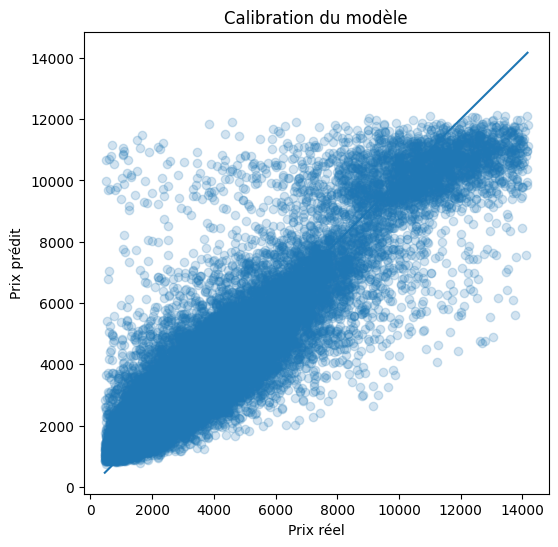

In [8]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.2)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()])
plt.xlabel("Prix réel")
plt.ylabel("Prix prédit")
plt.title("Calibration du modèle")
plt.show()

**SURROGATE MODEL**

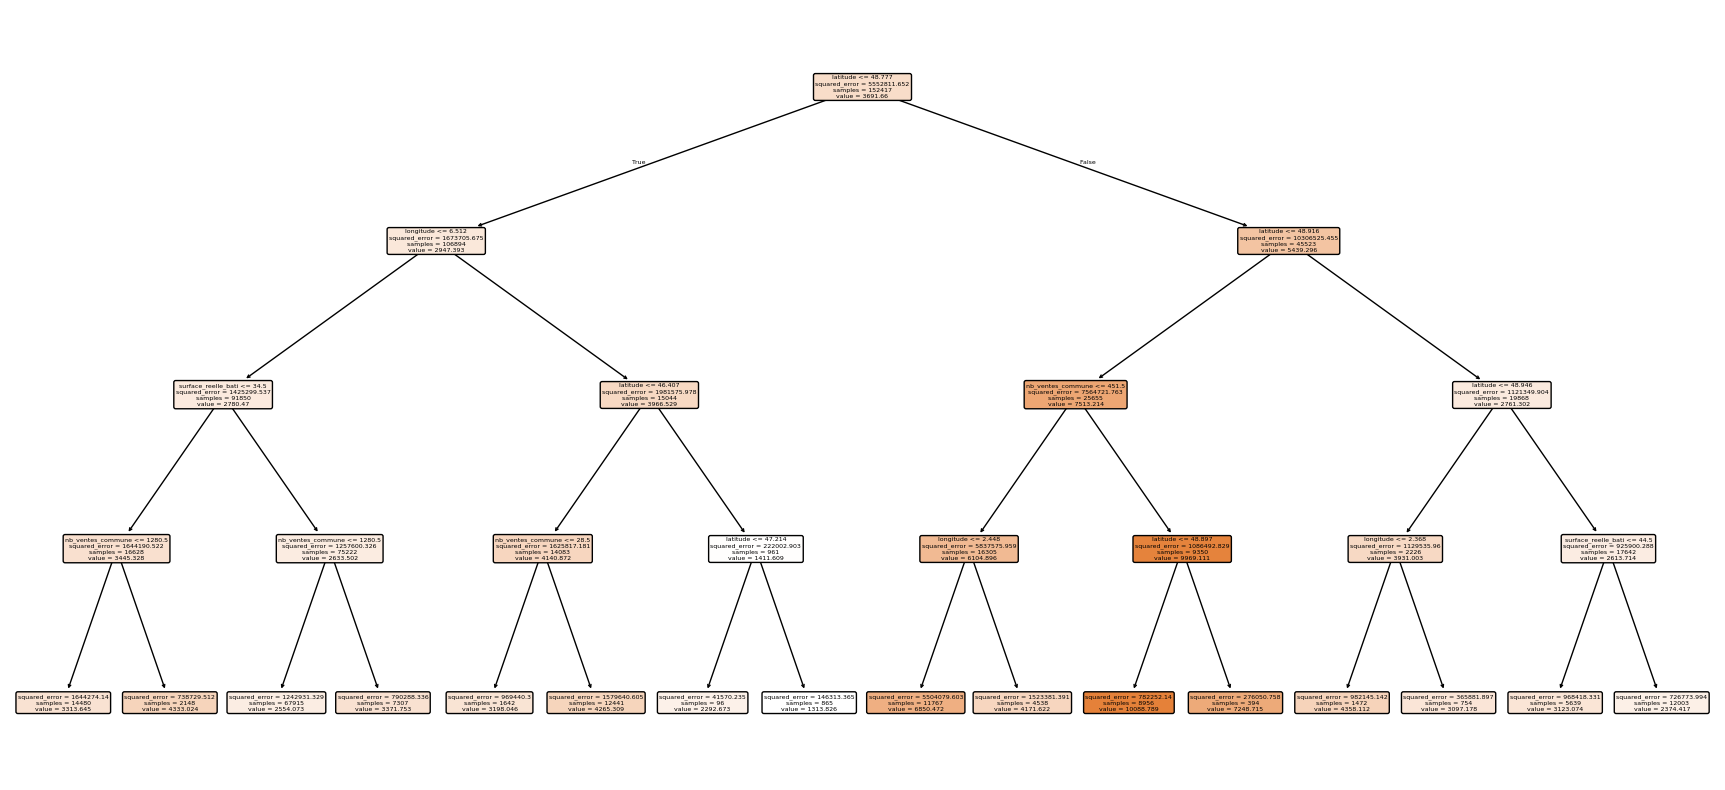

In [9]:
surrogate = DecisionTreeRegressor(
    max_depth=4,
    random_state=42
)

surrogate.fit(
    X_train_final,
    rf_model.predict(X_train_final)
)

plt.figure(figsize=(22, 10))
plot_tree(
    surrogate,
    feature_names=FEATURES_FINAL,
    filled=True,
    rounded=True
)
plt.show()